In [24]:
#Aman Penmetcha
#Written for AVATRINA,  Feb 2022
#Code to generate 360 Birds eye of TRINA surrounding using 4 usb cameras

from re import sub
from turtle import back, left, right
from cv2 import destroyAllWindows
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
import io
import imutils
cv2.ocl.setUseOpenCL(False)

#where is each camera
frontIndex = 0
leftIndex = 1
backIndex = 3
rightIndex = 2
spareCam = 3

#cv2.undistort(img, mtx, dist, None, newcameramtx)
#mtx, dist, newcameramtx

frontMtx = np.load(r'C:\Users\Aman\Desktop\School\Python\TRINA\IntrinsicsData\frontMtx.npy')
frontDist = np.load(r'C:\Users\Aman\Desktop\School\Python\TRINA\IntrinsicsData\frontDist.npy')
frontNewCameraMatrix = np.load(r'C:\Users\Aman\Desktop\School\Python\TRINA\IntrinsicsData\frontNewCameraMatrix.npy')
frontROI= np.load(r'C:\Users\Aman\Desktop\School\Python\TRINA\IntrinsicsData\frontROI.npy')

# print(frontROI)

leftMtx = np.load(r'C:\Users\Aman\Desktop\School\Python\TRINA\IntrinsicsData\leftMtx.npy')
leftDist = np.load(r'C:\Users\Aman\Desktop\School\Python\TRINA\IntrinsicsData\leftDist.npy')
leftNewCameraMatrix = np.load(r'C:\Users\Aman\Desktop\School\Python\TRINA\IntrinsicsData\leftNewCameraMatrix.npy')
leftROI= np.load(r'C:\Users\Aman\Desktop\School\Python\TRINA\IntrinsicsData\leftROI.npy')

backMtx = np.load(r'C:\Users\Aman\Desktop\School\Python\TRINA\IntrinsicsData\backMtx.npy')
backDist = np.load(r'C:\Users\Aman\Desktop\School\Python\TRINA\IntrinsicsData\backDist.npy')
backNewCameraMatrix = np.load(r'C:\Users\Aman\Desktop\School\Python\TRINA\IntrinsicsData\backNewCameraMatrix.npy')
backROI = np.load(r'C:\Users\Aman\Desktop\School\Python\TRINA\IntrinsicsData\backROI.npy')

rightMtx = np.load(r'C:\Users\Aman\Desktop\School\Python\TRINA\IntrinsicsData\rightMtx.npy')
rightDist = np.load(r'C:\Users\Aman\Desktop\School\Python\TRINA\IntrinsicsData\rightDist.npy')
rightNewCameraMatrix = np.load(r'C:\Users\Aman\Desktop\School\Python\TRINA\IntrinsicsData\rightNewCameraMatrix.npy')
rightROI= np.load(r'C:\Users\Aman\Desktop\School\Python\TRINA\IntrinsicsData\rightROI.npy')

#Set and get frame size example
# cap = cv2.VideoCapture(0)
# cap.set(cv2.CAP_PROP_FRAME_WIDTH, 300)
# cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 400)
# width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
# height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
# print(width, height)

##########
#this function takes the file name as a string eg: rightCamDesired.png and which camera: 1, 3, 5, or 7 and
#stores a image to later calculate homography with

def takePicture(fileName, camNumber):
    cap = cv2.VideoCapture(camNumber) #choose which camera
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    width1 = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    height1 = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    print(width1, height1)
    while(True):
        ret, frame = cap.read() # return a single frame in variable `frame`
        cv2.imshow('Take Picture for: ' + fileName + '||| y for take picture q for dont take picture', frame) #display the captured image
        if cv2.waitKey(1) & 0xFF == ord('y'): #save on pressing 'y' 
            cv2.imwrite(fileName, frame)
            cv2.destroyAllWindows()
            break
        elif cv2.waitKey(1) == ord('q'): #dont save the picture on pressing 'q'
            print('No picture taken')
            cv2.destroyAllWindows()
            break

    cap.release()


def calibrate():
    #taking pics for the gram 

    takePicture('backCamActual.png', backIndex)
    takePicture('backCamDesired.png', spareCam)

    takePicture('frontCamActual.png', frontIndex)
    takePicture('frontCamDesired.png', spareCam) 
    takePicture('rightCamActual.png', rightIndex)  
    takePicture('rightCamDesired.png',  spareCam) 
    takePicture('leftCamActual.png', leftIndex)
    takePicture('leftCamDesired.png', spareCam)
    
    

    # takePicture('frontStitchingImage.png', frontIndex)
    # takePicture('leftStitchingImage.png', leftIndex)
    # takePicture('backStitchingImage.png', backIndex)
    # takePicture('rightStitchingImage.png', rightIndex)

#functions for stitching below
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create(nfeatures = 50000)
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

#comment out calibrate line below if you want to skip calibration 
#if not commented you can still skip taking pictures but you will have to press q 8 times
# calibrate()

#images paths to calculate top down homography from
pathFrontCamActual = r'C:\Users\Aman\Desktop\School\Python\TRINA\frontCamActual.png'
pathFrontCamDesired = r'C:\Users\Aman\Desktop\School\Python\TRINA\frontCamDesired.png'
pathRightCamActual = r'C:\Users\Aman\Desktop\School\Python\TRINA\rightCamActual.png'
pathRightCamDesired = r'C:\Users\Aman\Desktop\School\Python\TRINA\rightCamDesired.png'
pathLeftCamActual = r'C:\Users\Aman\Desktop\School\Python\TRINA\leftCamActual.png'
pathLeftCamDesired = r'C:\Users\Aman\Desktop\School\Python\TRINA\leftCamDesired.png'
pathBackCamActual = r'C:\Users\Aman\Desktop\School\Python\TRINA\backCamActual.png'
pathBackCamDesired = r'C:\Users\Aman\Desktop\School\Python\TRINA\backCamDesired.png'


frontActual = cv2.imread(pathFrontCamActual)
frontDesired = cv2.imread(pathFrontCamDesired)
rightActual = cv2.imread(pathRightCamActual)
rightDesired = cv2.imread(pathRightCamDesired)
leftActual = cv2.imread(pathLeftCamActual)
leftDesired = cv2.imread(pathLeftCamDesired)
backActual = cv2.imread(pathBackCamActual)
backDesired = cv2.imread(pathBackCamDesired)

def undistortImage(img, mtx, dist, newcameramtx, roi):
    h,  w = img.shape[:2]
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
    # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    return dst

# frontActual = undistortImage(frontActual, frontMtx, frontDist, frontNewCameraMatrix, frontROI)
# frontDesired = undistortImage(frontDesired, frontMtx, frontDist, frontNewCameraMatrix, frontROI)
# rightActual = undistortImage(rightActual, rightMtx, rightDist, rightNewCameraMatrix, rightROI)
# rightDesired = undistortImage(rightDesired, rightMtx, rightDist, rightNewCameraMatrix, rightROI)
# leftActual = undistortImage(leftActual, leftMtx, leftDist, leftNewCameraMatrix, leftROI)
# leftDesired = undistortImage(leftDesired, leftMtx, leftDist, leftNewCameraMatrix, leftROI)
# backActual = undistortImage(backActual, backMtx, backDist, backNewCameraMatrix, backROI)
# backDesired = undistortImage(backDesired, backMtx, backDist, backNewCameraMatrix, backROI)

frontActual = undistortImage(frontActual, frontMtx, frontDist, frontNewCameraMatrix, frontROI)
frontDesired = undistortImage(frontDesired, frontMtx, frontDist, frontNewCameraMatrix, frontROI)
rightActual = undistortImage(rightActual, rightMtx, rightDist, rightNewCameraMatrix, rightROI)
rightDesired = undistortImage(rightDesired, rightMtx, rightDist, rightNewCameraMatrix, rightROI)
leftActual = undistortImage(leftActual, leftMtx, leftDist, leftNewCameraMatrix, leftROI)
leftDesired = undistortImage(leftDesired, leftMtx, leftDist, leftNewCameraMatrix, leftROI)
backActual = undistortImage(backActual, backMtx, backDist, backNewCameraMatrix, backROI)
backDesired = undistortImage(backDesired, backMtx, backDist, backNewCameraMatrix, backROI)

t = time.time()

#patternSize stores the size of the chessboard you are looking for
patternSize = (8,6)


retFA, cornersFrontActual = cv2.findChessboardCorners(frontActual, patternSize)
retFD, cornersFrontDesired = cv2.findChessboardCorners(frontDesired, patternSize)
retRA, cornersRightActual = cv2.findChessboardCorners(rightActual, patternSize)
retRD, cornersRightDesired = cv2.findChessboardCorners(rightDesired, patternSize)
retLA, cornersLeftActual = cv2.findChessboardCorners(leftActual, patternSize)
retLD, cornersLeftDesired = cv2.findChessboardCorners(leftDesired, patternSize)
retBA, cornersBackActual = cv2.findChessboardCorners(backActual, patternSize)
retBD, cornersBackDesired = cv2.findChessboardCorners(backDesired, patternSize)

Hfront, _1 = cv2.findHomography(cornersFrontActual, cornersFrontDesired)
Hright, _2 = cv2.findHomography(cornersRightActual, cornersRightDesired)
Hleft, _3 = cv2.findHomography(cornersLeftActual, cornersLeftDesired)
Hback, _4 = cv2.findHomography(cornersBackActual, cornersBackDesired)
print("Top Down Matricies Computed")

# imgTemp1 = cv2.warpPerspective(cv2.imread(r'C:\Users\Aman\Desktop\School\Python\frontStitchingImage.png'), Hfront, (frontActual.shape[1], frontActual.shape[0]))
# cv2.imwrite('frontStitchingImageWarped.png', imgTemp1)
# imgTemp2 = cv2.warpPerspective(cv2.imread(r'C:\Users\Aman\Desktop\School\Python\leftStitchingImage.png'), Hleft, (frontActual.shape[1], frontActual.shape[0]))
# cv2.imwrite('leftStitchingImageWarped.png', imgTemp2)
# print("Done")
# cv2.imshow('Front Cam Warped', frontCam_warp)
# cv2.imshow('Right Cam Warped', rightCam_warp)
# cv2.imshow('Left Cam Warped', leftCam_warp)

#stitching starts here
feature_extractor = 'orb' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'

#images to calculate stitching matricies from
frontStitchImage = cv2.imread(r'C:\Users\Aman\Desktop\School\Python\TRINA\frontStitchingImage.png')
leftStitchImage = cv2.imread(r'C:\Users\Aman\Desktop\School\Python\TRINA\leftStitchingImage.png')
backStitchImage = cv2.imread(r'C:\Users\Aman\Desktop\School\Python\TRINA\backStitchingImage.png')
rightStitchImage = cv2.imread(r'C:\Users\Aman\Desktop\School\Python\TRINA\rightStitchingImage.png')

# cv2.imshow('front path', frontStitchImage)
# cv2.imshow('left path', leftStitchImage)
# cv2.imshow('back path', backStitchImage)
# cv2.imshow('right path', rightStitchImage)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

frontStitchImage = undistortImage(frontStitchImage, frontMtx, frontDist, frontNewCameraMatrix, frontROI)
leftStitchImage = undistortImage(leftStitchImage, leftMtx, leftDist, leftNewCameraMatrix, leftROI)
backStitchImage = undistortImage(backStitchImage, backMtx, backDist, backNewCameraMatrix, backROI)
rightStitchImage = undistortImage(rightStitchImage, rightMtx, rightDist, rightNewCameraMatrix, rightROI)

# cv2.imshow('front undistort', frontStitchImage)
# cv2.imshow('left undistort', leftStitchImage)
# cv2.imshow('back undistort', backStitchImage)
# cv2.imshow('right undistort', rightStitchImage)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

#test images
# frontStitchImage = cv2.imread(r'C:\Users\Aman\Desktop\TRINA\OPENCV\LabTest\imgF.png')
# leftStitchImage = cv2.imread(r'C:\Users\Aman\Desktop\TRINA\OPENCV\LabTest\imgL.png')
# backStitchImage = cv2.imread(r'C:\Users\Aman\Desktop\TRINA\OPENCV\LabTest\imgB.png')
# rightStitchImage = cv2.imread(r'C:\Users\Aman\Desktop\TRINA\OPENCV\LabTest\imgR.png')


#pass in the grayscale of images that need to be stitched (these will be the top down warped images)
#needs both grayscale and normal to compute the stitching matrix properly
def calculateStitchingMatrix(img1, img1Gray, img2, img2Gray):
    kpsA, featuresA = detectAndDescribe(img1Gray, method=feature_extractor)
    kpsB, featuresB = detectAndDescribe(img2Gray, method=feature_extractor)
    

    # display the keypoints and features detected on both images
    # fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
    # ax1.imshow(cv2.drawKeypoints(img1,kpsA,None,color=(0,255,0)))
    # ax1.set_xlabel("(a)", fontsize=14)
    # ax2.imshow(cv2.drawKeypoints(img2,kpsB,None,color=(0,255,0)))
    # ax2.set_xlabel("(b)", fontsize=14)
    # plt.show()

    if feature_matching == 'bf':
        matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
        img3 = cv2.drawMatches(img1,kpsA,img2,kpsB,matches[:100],
                            None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    elif feature_matching == 'knn':
        matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
        img3 = cv2.drawMatches(img1,kpsA,img2,kpsB,np.random.choice(matches,100),
                            None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.imshow(img3)
    plt.show()

    M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
    if M is None:
        print("Error! Stitching Homography Matrix couldnt be calculated for kpsA and kpsB")
    (matches, Hstitch, status) = M
    return Hstitch

def warpTwoImages(img1, img2, H):
    '''warp img2 to img1 with homograph H'''
    mask = np.all(img1==np.array([0,0,0]).reshape(1,1,3), axis = 2)

    blackPixels = np.where(mask == False)
#     print(blackPixels)
    
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate
    
    

    result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
    
    result[t[1]+blackPixels[0],t[0]+blackPixels[1],:] = img1[blackPixels[0],blackPixels[1],:]
    return result


def warpSingleImage(img,H):
    h,w = img.shape[:2]
    print(h,w)
    pts = np.float32([[0,0],[0,h],[w,h],[w,0]]).reshape(-1,1,2)
    pts = cv2.perspectiveTransform(pts,H)
    print(pts)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
#     template = np.zeros((xmax-xmin,ymax-ymin,3))
    t = [-xmin,-ymin]
    print(t,xmax,ymax)
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate
    result = cv2.warpPerspective(img, Ht.dot(H), (xmax-xmin, ymax-ymin))
    # result = cv2.resize(result,(720,1280))
#     template[t[1]:h+t[1],t[0]:w+t[0]] = result
    return result

#applies top down homography Uncomment next block of 4 lines if you want this to run
# frontStitchImage_warp = cv2.warpPerspective(frontStitchImage, Hfront, (frontStitchImage.shape[1], frontStitchImage.shape[0]))
# leftStitchImage_warp = cv2.warpPerspective(leftStitchImage, Hleft, (leftStitchImage.shape[1], leftStitchImage.shape[0]))
# backStitchImage_warp = cv2.warpPerspective(backStitchImage, Hback, (backStitchImage.shape[1], backStitchImage.shape[0]))
# rightStitchImage_warp = cv2.warpPerspective(rightStitchImage, Hright, (rightStitchImage.shape[1], rightStitchImage.shape[0]))

#top down no cropping
frontStitchImage_warp = warpSingleImage(frontStitchImage, Hfront)
leftStitchImage_warp = warpSingleImage(leftStitchImage, Hleft)
backStitchImage_warp = warpSingleImage(backStitchImage, Hback)
rightStitchImage_warp = warpSingleImage(rightStitchImage, Hright)

# cv2.imwrite('frontStitch_warped.png', frontStitchImage_warp)
# cv2.imwrite('leftStitch_warped.png', leftStitchImage_warp)
# cv2.imwrite('backStitch_warped.png', backStitchImage_warp)
# cv2.imwrite('rightStitch_warped.png', rightStitchImage_warp)


# skips top down homography for debugging
# frontStitchImage_warp = frontStitchImage
# leftStitchImage_warp = leftStitchImage
# backStitchImage_warp = backStitchImage
# rightStitchImage_warp = rightStitchImage

#show the warped stitching images
cv2.imshow('front', frontStitchImage_warp)
cv2.imshow('left', leftStitchImage_warp)
cv2.imshow('back', backStitchImage_warp)
cv2.imshow('right', rightStitchImage_warp)
cv2.waitKey(0)
cv2.destroyAllWindows()

frontStitchImage_warp_gray = cv2.cvtColor(frontStitchImage_warp, cv2.COLOR_RGB2GRAY)
leftStitchImage_warp_gray = cv2.cvtColor(leftStitchImage_warp, cv2.COLOR_RGB2GRAY)
backStitchImage_warp_gray = cv2.cvtColor(backStitchImage_warp, cv2.COLOR_RGB2GRAY)
rightStitchImage_warp_gray = cv2.cvtColor(rightStitchImage_warp, cv2.COLOR_RGB2GRAY)

Top Down Matricies Computed
531 1017
[[[-231.22206  -189.0439  ]]

 [[ 122.424515  493.15924 ]]

 [[ 962.08093   541.1207  ]]

 [[1746.6477   -419.74792 ]]]
[231, 420] 1747 541
539 979
[[[-900.171   -761.6528 ]]

 [[ 100.46741  456.37323]]

 [[ 879.52435  467.4795 ]]

 [[1708.6812  -598.13934]]]
[900, 762] 1709 467
488 903
[[[ -949.67725  -982.7992 ]]

 [[  106.03221   341.52768]]

 [[  884.3673    343.29608]]

 [[ 3482.5813  -2390.8342 ]]]
[950, 2391] 3483 343
536 980
[[[-1400.1064  -1501.3992 ]]

 [[   96.19423   355.5686 ]]

 [[  910.1587    403.12082]]

 [[ 2395.1638  -1181.142  ]]]
[1400, 1501] 2395 403


Raw matches (Brute force): 2562


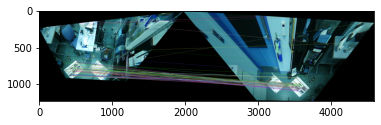

Raw matches (Brute force): 1724


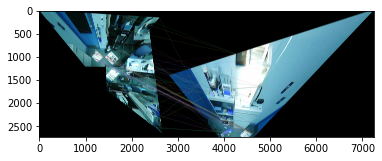

Raw matches (Brute force): 4435


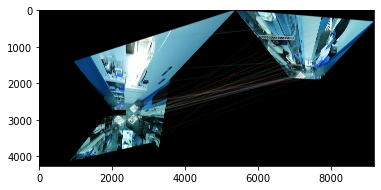

DONE COMPUTING


In [26]:
HFL = calculateStitchingMatrix(frontStitchImage_warp, frontStitchImage_warp_gray, leftStitchImage_warp, leftStitchImage_warp_gray)
subStitchFL = warpTwoImages(leftStitchImage_warp, frontStitchImage_warp, HFL)

subStitchFL_gray = cv2.cvtColor(subStitchFL, cv2.COLOR_RGB2GRAY)
HFLB = calculateStitchingMatrix(subStitchFL, subStitchFL_gray, backStitchImage_warp, backStitchImage_warp_gray)

subStitchFLB = warpTwoImages(backStitchImage_warp, subStitchFL, HFLB)

subStitchFLB_gray = cv2.cvtColor(subStitchFLB, cv2.COLOR_RGB2GRAY)
HFLBR = calculateStitchingMatrix(subStitchFLB, subStitchFLB_gray, rightStitchImage_warp, rightStitchImage_warp_gray)
subStitchFLBR = warpTwoImages(rightStitchImage_warp, subStitchFLB, HFLBR)
cv2.imwrite('finalOutput.png', subStitchFLBR)
subStitchFLBR = cv2.resize(subStitchFLBR, (720, 1280))
cv2.imshow('subStitchFLBR', subStitchFLBR)
cv2.waitKey(0)
cv2.destroyAllWindows()

print("DONE COMPUTING")

In [8]:
# capFront = cv2.VideoCapture(frontIndex)
# capLeft = cv2.VideoCapture(leftIndex)
# capBack = cv2.VideoCapture(backIndex)
# capRight = cv2.VideoCapture(rightIndex)

# pTime = 0
# while True:
#     cTime = time.time()
#     fps = 1/(cTime - pTime)
#     pTime = cTime

#     ret, frameFront = capFront.read()
#     ret, frameLeft = capLeft.read()
#     ret, frameBack = capBack.read()
#     ret, frameRight = capRight.read()

#     frameFront= undistortImage(frameFront, frontMtx, frontDist, frontNewCameraMatrix, frontROI)
#     frameLeft = undistortImage(frameLeft, leftMtx, leftDist, leftNewCameraMatrix, leftROI)
#     frameBack = undistortImage(frameBack, backMtx, backDist, backNewCameraMatrix, backROI)
#     frameRight = undistortImage(frameRight, rightMtx, rightDist, rightNewCameraMatrix, rightROI)

#     #circumventing top down homography for testing
#     # frontCam_warp = frameFront
#     # leftCam_warp = frameLeft
#     # backCam_warp = frameBack
#     # rightCam_warp = frameRight 

#     frontCam_warp = cv2.warpPerspective(frameFront, Hfront, (frontActual.shape[1], frontActual.shape[0]))
#     leftCam_warp = cv2.warpPerspective(frameLeft, Hleft, (leftActual.shape[1], leftActual.shape[0]))
#     backCam_warp = cv2.warpPerspective(frameBack, Hback, (backActual.shape[1], backActual.shape[0]))
#     rightCam_warp = cv2.warpPerspective(frameRight, Hright, (rightActual.shape[1], rightActual.shape[0]))

#     subStitchFL = warpTwoImages(leftCam_warp, frontCam_warp, HFL)
#     subStitchFL_gray = cv2.cvtColor(subStitchFL, cv2.COLOR_RGB2GRAY)
#     subStitchFLB = warpTwoImages(backCam_warp, subStitchFL, HFLB)
#     subStitchFLB_gray = cv2.cvtColor(subStitchFLB, cv2.COLOR_RGB2GRAY)
#     subStitchFLBR = warpTwoImages(rightCam_warp, subStitchFLB, HFLBR)

#     #display the result of top down homography and stitching
#     result = subStitchFLBR

#     result = cv2.resize(result, (1280, 720))
    
#     cv2.putText(result, str(int(fps)), (10,70), cv2.FONT_HERSHEY_PLAIN, 3, (255,0,255),3)
#     cv2.imshow('front', frontCam_warp)
#     cv2.imshow('left', leftCam_warp)
#     cv2.imshow('back', backCam_warp)
#     cv2.imshow('right', rightCam_warp)

#     cv2.imshow('', result)
#     if cv2.waitKey(1) == ord('q'):
#         print(fps)
#         cv2.destroyAllWindows()
#         break




    